In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [25]:
def getMiscDict(path):
    dirList = path.split('\\')
    syncType = dirList[len(dirList) - 7]
    memoryStorage = dirList[len(dirList) - 6]
    baseline = dirList[len(dirList) -5]
    if baseline == 'Comp':
        baseline = 'TACO'
    elif baseline == 'Async':
        baseline = 'Anti-freeze'
    elif baseline == 'PGImpl':
        baseline = 'NoCompe'
    testSpreadsheet = dirList[len(dirList) - 4]
    run = int(dirList[len(dirList) - 3].split('-')[1])
    rows = int(dirList[len(dirList) - 2].split('-')[1])
    return {'Sync/Async':syncType, 'Memory Storage':memoryStorage, 'Baseline':baseline,
            'Test Spreadsheet':testSpreadsheet, 'Run':run, 'Rows':rows}

def getMetrics(path):
    """
    Takes in a path string to a .stat file and returns a Pandas DataFrame of the file's contents
    """
    reportsFile = open(path, 'r')
    dataDict = {}
    dataDict = getMiscDict(path)
    for line in reportsFile:
        if ': ' in line:
            metric, value = line.split(": ")
            if metric not in dataDict:
                dataDict[metric] = []
            try:
                dataDict[metric].append(int(value))
            except ValueError:
                dataDict[metric].append(float(value))
            except:
                dataDict[metric].append(value)
    reportsFile.close
    
    return pd.DataFrame(dataDict)


def getAllMetrics(basePath, miscDict={'sync type':'', 'mem type':'', 'impl':'', 'test':'', 'run':0}):
    """
    Takes in a file path and searches all of its subdirectories for .stat files and returns all of
    their contents in a Pandas DataFrame
    """
    data = pd.DataFrame()
    for file in os.listdir(basePath):
        filePath = os.path.join(basePath, file)
        if os.path.isdir(filePath):
            data = data.append(getAllMetrics(filePath))
        elif file == "core.stat":
            data = data.append(getMetrics(filePath))
    return data


def plotAll(data, sheets=['Rate', 'RunningTotalFast', 'RunningTotalSlow'], syncMethod=['async', 'sync']):
    plt.figure()
    #print(plt.rcParams.keys())
    plt.rcParams.update({'font.size': 15, 'figure.figsize': (12,8), 'lines.linewidth':3, 'axes.grid':True})
    for sheet in sheets:
        for sync in syncMethod:
            dataSlice = data.loc[sheet, sync]
            #display(dataSlice)
            totalTestTimeData = pd.pivot_table(dataSlice, index='Rows', columns=dataSlice.index)['Total time to update cells (ms)']
            totalTestTimePlot = totalTestTimeData.plot.line()
            if sync=='sync':
                totalTestTimePlot.set_title('Number of Rows vs Time to Update Spreadsheet (' + sheet + ', ' + sync + ')')
            elif sync=='async':
                totalTestTimePlot.set_title('Number of Rows vs Time to Return Control to User (' + sheet + ', ' + sync + ')')
            totalTestTimePlot.set_ylabel('Total Time in ms')
            
            if sync=='sync':
                dataSlice = pd.pivot_table(dataSlice, index='Rows', columns=dataSlice.index)['Total time of adding the batch (ms)']
                batchPlot = dataSlice.plot.line()
                batchPlot.set_title('Number of Rows vs Total Time Adding to the Batch (' + sheet + ')')
                batchPlot.set_ylabel('Total Time in ms')

<Figure size 864x576 with 0 Axes>

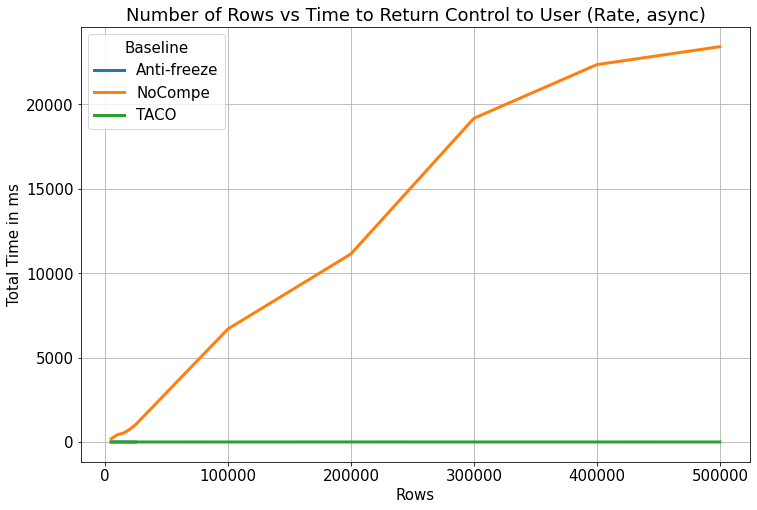

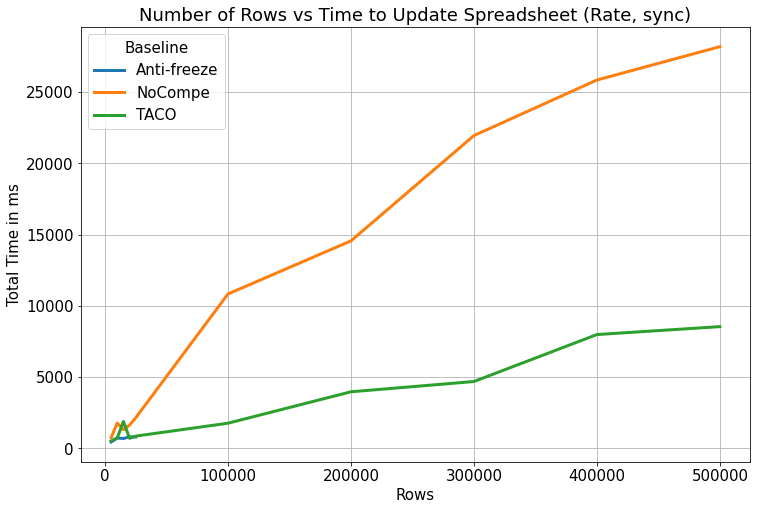

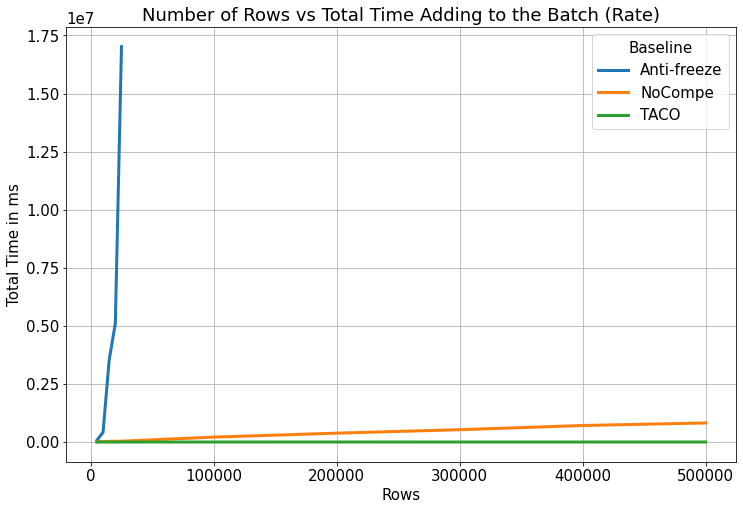

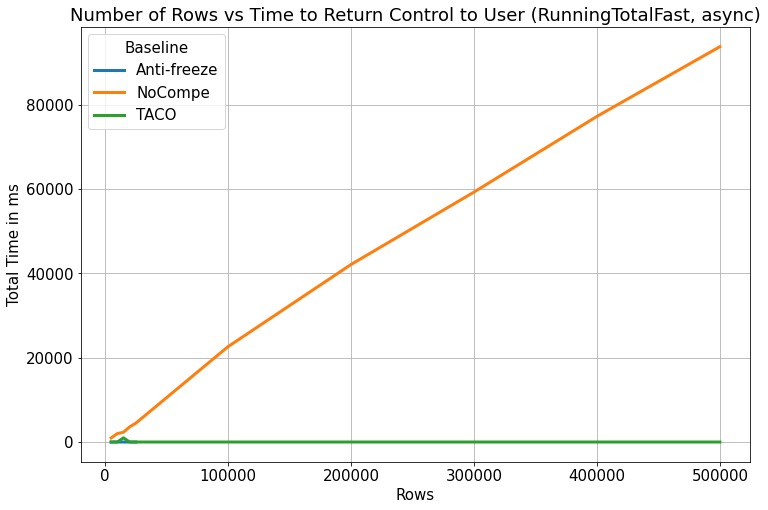

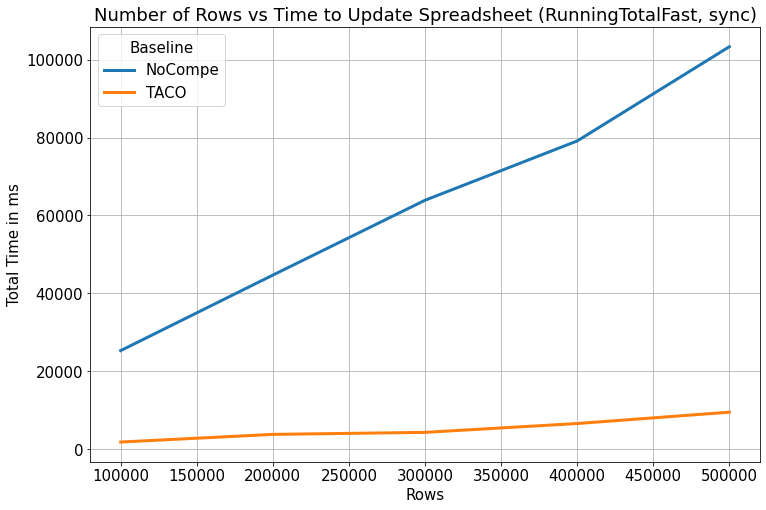

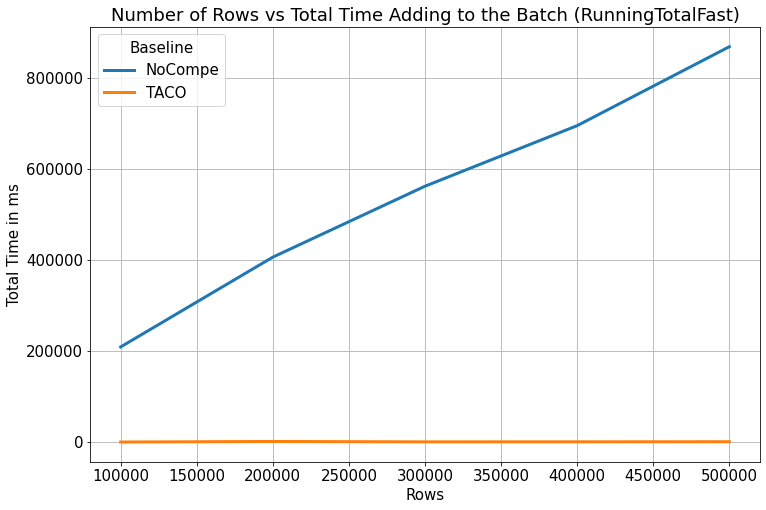

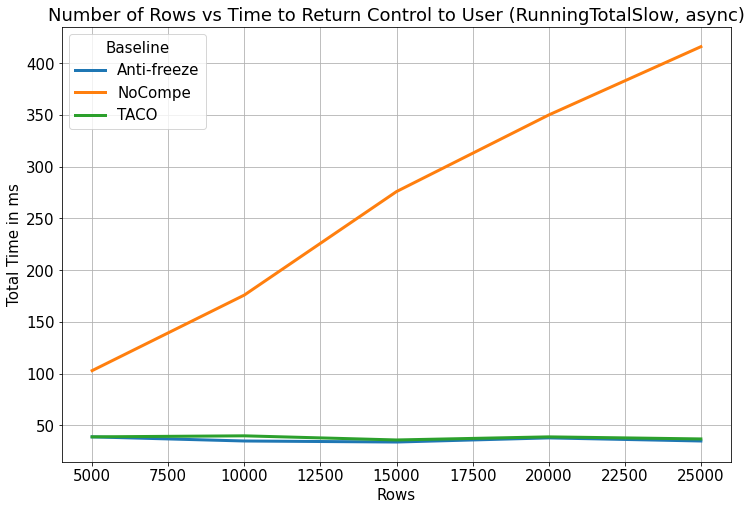

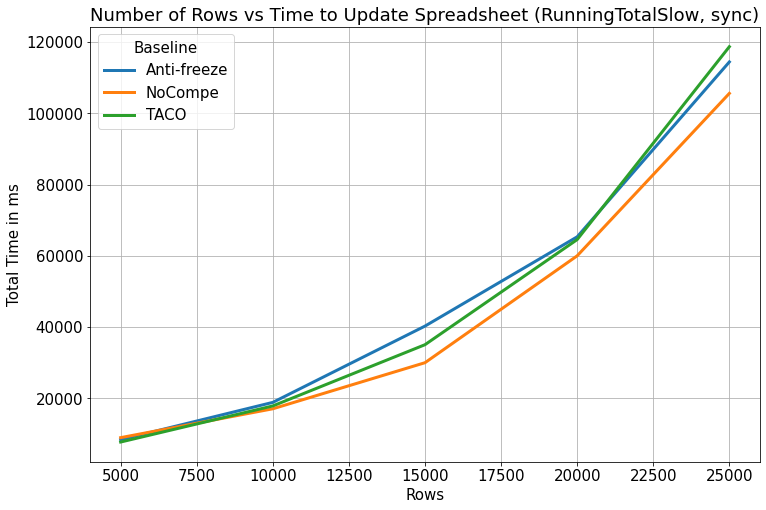

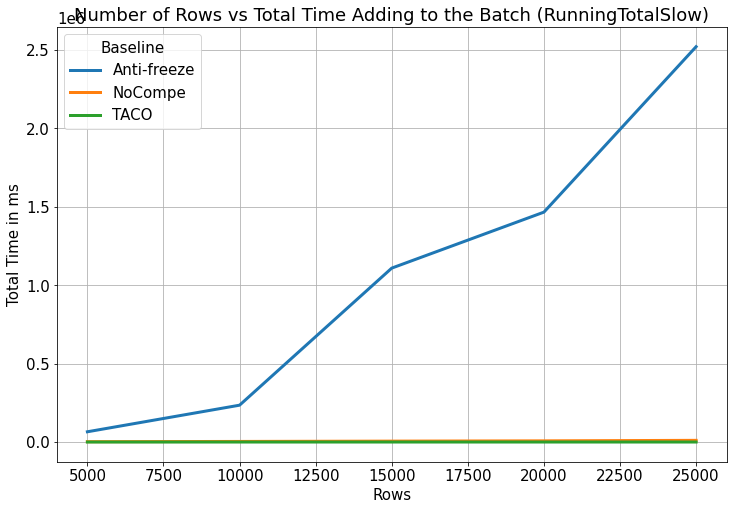

In [26]:
# Formua Compression Test path (CHANGE)
formulaCompressionTestHome = "C:\\Users\\jonat\\Documents\\Dataspread\\FormulaCompressionTest"
testPath = formulaCompressionTestHome + "\\Chris\\FormulaCompressionTesting\\testing\\reports"

pd.set_option('max_rows', 115)
testData = getAllMetrics(testPath)
#display(testData)
testData = testData.groupby(['Test Spreadsheet', 'Sync/Async', 'Baseline', 'Rows']).median()
testData = testData.reset_index(level='Rows')
plotAll(testData)